# National Weather Service (NWS) API in Python

by Michael T. Moen

**NWS API documentation:** https://www.weather.gov/documentation/services-web-api

**NWS terms of use:** From the documentation, "All of the information presented via the API is intended to be open data, free to use for any purpose."

*These recipe examples were tested on February 23, 2024.*

**_NOTE:_** The NWS API imposes a rate limit on requests, but the amount is not published. We recommend using a 1 second delay between API requests.

## Setup

### User Agent Information

A User Agent is required to access the NWS API. The User Agent identifies what application or program the is accessing the NWS API.

Add your application name and email below:

In [2]:
user_agent = {"User-Agent": "Application name, email@domain.com"}

Alternatively, you can save the above data in a separate python file and import it:

In [3]:
from user_agent import user_agent

### Import Libraries

This tutorial uses the following libraries:

In [4]:
import requests                     # Manages API requests
import matplotlib.pyplot as plt     # Creates visualization of data
import matplotlib.dates as mdates   # Provides functionality for working with dates in matplotlib plots
from time import sleep              # Allows staggering of API requests to conform to rate limits
from dateutil import parser         # Parses datetime strings into datetime objects

## 1. Get the 12 hour forecast for a location

The NWS publishes weather forecasts for each of its Weather Forecast Offices. A map of these offices and the regions they cover can be found here: https://www.weather.gov/srh/nwsoffices

In order to obtain the forecast for a location, we must query that region's Weather Forecast Office using its code and the grid coordinates of the location. To determine these values for a location, we can query the `/points` endpoint.

In [5]:
latitude = '33.211952'
longitude = '-87.545920'

url = f'https://api.weather.gov/points/{latitude},{longitude}'
response = requests.get(url, headers=user_agent).json()

# Display response from API
response

{'@context': ['https://geojson.org/geojson-ld/geojson-context.jsonld',
  {'@version': '1.1',
   'wx': 'https://api.weather.gov/ontology#',
   's': 'https://schema.org/',
   'geo': 'http://www.opengis.net/ont/geosparql#',
   'unit': 'http://codes.wmo.int/common/unit/',
   '@vocab': 'https://api.weather.gov/ontology#',
   'geometry': {'@id': 's:GeoCoordinates', '@type': 'geo:wktLiteral'},
   'city': 's:addressLocality',
   'state': 's:addressRegion',
   'distance': {'@id': 's:Distance', '@type': 's:QuantitativeValue'},
   'bearing': {'@type': 's:QuantitativeValue'},
   'value': {'@id': 's:value'},
   'unitCode': {'@id': 's:unitCode', '@type': '@id'},
   'forecastOffice': {'@type': '@id'},
   'forecastGridData': {'@type': '@id'},
   'publicZone': {'@type': '@id'},
   'county': {'@type': '@id'}}],
 'id': 'https://api.weather.gov/points/33.212,-87.5459',
 'type': 'Feature',
 'geometry': {'type': 'Point', 'coordinates': [-87.5459, 33.212]},
 'properties': {'@id': 'https://api.weather.gov/poi

In [6]:
office = response["properties"]["gridId"]
gridX = response["properties"]["gridX"]
gridY = response["properties"]["gridY"]

# Print grid location data
print(f'Office code: {office}, Grid coordinates: {gridX}, {gridY}')

Office code: BMX, Grid coordinates: 33, 69


Now that we have obtained the grid coordinates and office code, we can use the `/gridpoints` endpoint to obtain the seven day forecast:

In [7]:
url = f'https://api.weather.gov/gridpoints/{office}/{gridX},{gridY}/forecast'
response = requests.get(url, headers=user_agent).json()

# Display first result
response["properties"]["periods"][0]

{'number': 1,
 'name': 'This Afternoon',
 'startTime': '2024-02-23T13:00:00-06:00',
 'endTime': '2024-02-23T18:00:00-06:00',
 'isDaytime': True,
 'temperature': 69,
 'temperatureUnit': 'F',
 'temperatureTrend': None,
 'probabilityOfPrecipitation': {'unitCode': 'wmoUnit:percent', 'value': None},
 'dewpoint': {'unitCode': 'wmoUnit:degC', 'value': 7.222222222222222},
 'relativeHumidity': {'unitCode': 'wmoUnit:percent', 'value': 45},
 'windSpeed': '10 to 15 mph',
 'windDirection': 'NW',
 'icon': 'https://api.weather.gov/icons/land/day/few?size=medium',
 'shortForecast': 'Sunny',
 'detailedForecast': 'Sunny, with a high near 69. Northwest wind 10 to 15 mph.'}

Finally, we can print the data we are interested in. In this case, we're looking at the temperature, probability of precipitation, and detailed forecast.

In [8]:
for day in response["properties"]["periods"]:
    name = day["name"]
    temperature = day["temperature"]
    rain = day["probabilityOfPrecipitation"]["value"] or 0
    forecast = day["detailedForecast"]
    print(f'{name:<16}: {temperature:>3}F, {rain:>3}%, {forecast}')

This Afternoon  :  69F,   0%, Sunny, with a high near 69. Northwest wind 10 to 15 mph.
Tonight         :  44F,   0%, Clear, with a low around 44. West wind 5 to 10 mph.
Saturday        :  66F,   0%, Sunny. High near 66, with temperatures falling to around 61 in the afternoon. Northwest wind 5 to 15 mph.
Saturday Night  :  35F,   0%, Clear, with a low around 35. Northeast wind 5 to 10 mph.
Sunday          :  69F,   0%, Sunny. High near 69, with temperatures falling to around 63 in the afternoon. Southeast wind 5 to 10 mph.
Sunday Night    :  48F,   0%, Mostly clear, with a low around 48.
Monday          :  77F,   0%, Sunny, with a high near 77.
Monday Night    :  59F,   0%, Partly cloudy, with a low around 59.
Tuesday         :  80F,   0%, Partly sunny, with a high near 80.
Tuesday Night   :  63F,  20%, A slight chance of rain showers after midnight. Mostly cloudy, with a low around 63. Chance of precipitation is 20%.
Wednesday       :  73F,  50%, A chance of showers and thunderstorms. 

## 2. Get the hourly forecast for a location

The `\gridpoints` endpoint can also return an hourly forecast for a seven day period. The function below implements the code from the example above using this hourly forecast method:

In [9]:
# Note that this function only works with valid latitude and longitude inputs
def getHourlyForecast(latitude, longitude, user_agent):
    
    points_url = f'https://api.weather.gov/points/{latitude},{longitude}'
    points_response = requests.get(points_url, headers=user_agent).json()
    office = points_response["properties"]["gridId"]
    gridX = points_response["properties"]["gridX"]
    gridY = points_response["properties"]["gridY"]

    sleep(1)    # Add 1 second delay between API requests

    # The addition of the "/hourly" to the end of this URL is the only difference between the hourly and daily forecasts
    gridpoints_url = f'https://api.weather.gov/gridpoints/{office}/{gridX},{gridY}/forecast/hourly'
    gridpoints_response = requests.get(gridpoints_url, headers=user_agent).json()
    return gridpoints_response["properties"]["periods"]

The function can be easily used as such:

In [10]:
latitude = '33.211952'
longitude = '-87.545920'
hourlyForecast = getHourlyForecast(latitude, longitude, user_agent)
len(hourlyForecast)

156

Lastly, we can use matplotlib to graph the temperature data:

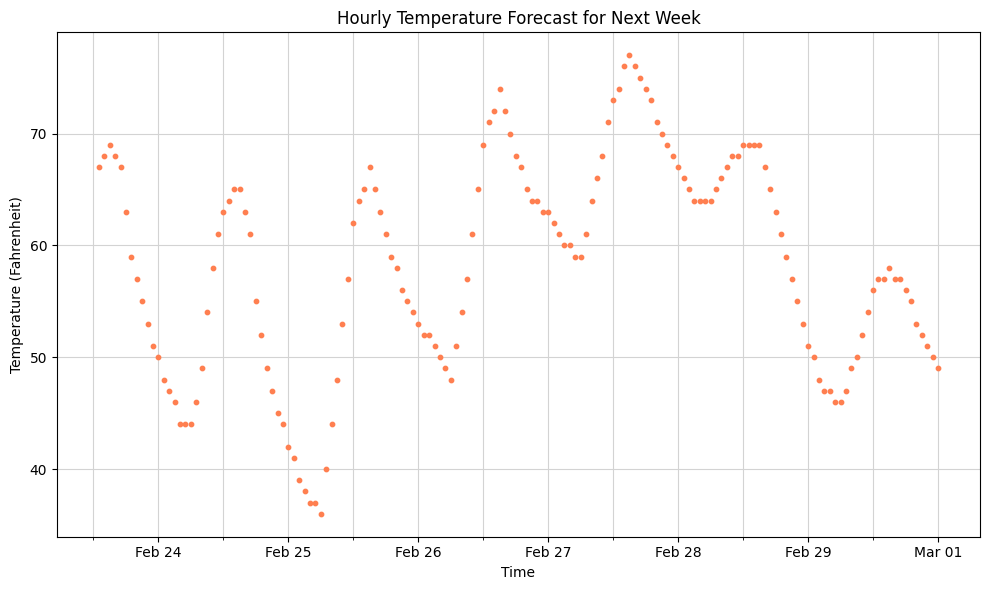

In [11]:
hours = []
temperatures = []
for hourForecast in hourlyForecast:
    hour = parser.parse(hourForecast["startTime"][:19])
    hours.append(hour)
    temperatures.append(hourForecast["temperature"])

plt.figure(figsize=(10, 6))
plt.scatter(hours, temperatures, color='coral', marker='o', s=10)
plt.title('Hourly Temperature Forecast for Next Week')
plt.xlabel('Time')
plt.ylabel('Temperature (Fahrenheit)')
plt.grid(True, which='both', color='lightgray')
plt.gca().set_axisbelow(True)
plt.gca().xaxis.set_major_locator(mdates.HourLocator(byhour=0))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.gca().xaxis.set_minor_locator(mdates.HourLocator(byhour=12))
plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter(''))
plt.tight_layout()
plt.show()

## 3. Get alerts for a location

*This use-case is for demonstration purposes. To get current weather alerts in the U.S., be sure to also check your local NWS website directly (e.g., for Birmingham, AL area, see: https://www.weather.gov/bmx/).*

The `/alerts` endpoint returns all alerts issued for a given location or area. The example below uses the `point` parameter to find all alerts for a pair of coordinates:

In [20]:
latitude = '33.211952'
longitude = '-87.545920'

url = f'https://api.weather.gov/alerts/active?point={latitude},{longitude}'
response = requests.get(url, headers=user_agent).json()

# Display response from API
response

{'@context': {'@version': '1.1'},
 'type': 'FeatureCollection',
 'features': [],
 'title': 'Current watches, warnings, and advisories for 33.211952 N, 87.54592 W',
 'updated': '2024-02-17T00:00:00+00:00'}

Note that there are no active alerts in the result above.

The example below uses the `area` parameter to find all alerts for the state of Alabama:

In [22]:
state = 'AL'

url = f'https://api.weather.gov/alerts/active?area={state}'
response = requests.get(url, headers=user_agent).json()

# Display response from API
response['features']

[{'id': 'https://api.weather.gov/alerts/urn:oid:2.49.0.1.840.0.bd6153ef80e4aa2cc8ef67860f33f8dccf01d19b.001.1',
  'type': 'Feature',
  'geometry': None,
  'properties': {'@id': 'https://api.weather.gov/alerts/urn:oid:2.49.0.1.840.0.bd6153ef80e4aa2cc8ef67860f33f8dccf01d19b.001.1',
   '@type': 'wx:Alert',
   'id': 'urn:oid:2.49.0.1.840.0.bd6153ef80e4aa2cc8ef67860f33f8dccf01d19b.001.1',
   'areaDesc': 'Mobile Coastal; Baldwin Coastal; Escambia Coastal; Santa Rosa Coastal; Okaloosa Coastal',
   'geocode': {'SAME': ['001097', '001003', '012033', '012113', '012091'],
    'UGC': ['ALZ265', 'ALZ266', 'FLZ202', 'FLZ204', 'FLZ206']},
   'affectedZones': ['https://api.weather.gov/zones/forecast/ALZ265',
    'https://api.weather.gov/zones/forecast/ALZ266',
    'https://api.weather.gov/zones/forecast/FLZ202',
    'https://api.weather.gov/zones/forecast/FLZ204',
    'https://api.weather.gov/zones/forecast/FLZ206'],
   'references': [],
   'sent': '2024-02-23T13:08:00-06:00',
   'effective': '2024-02

As we can see from the example above, there is one alert in the state of Alabama:

In [24]:
response['features'][0]['properties']['headline']

'Rip Current Statement issued February 23 at 1:08PM CST until February 24 at 6:00AM CST by NWS Mobile AL'